<h3> Summary of this notebook: </h3>

- NMT model using Transformer using sub-classed layers
- Training works
- Two separate functions for evaluating: "translate()", which uses original sentence, and "random_translate_from_tensor", which translates from random sequence in source_tensor
- Plotting of attention weights works
- Saving works
- Moved most helper functions, subclassed layers, and Transformer object into "model_components.py" file

In [82]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Concatenate, LSTM, Embedding, Dense, MultiHeadAttention, LayerNormalization, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time




In [83]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/ColabNotebooks/train_translate

In [84]:
from model_components import preprocess_sentence, get_angles, positional_encoding, create_padding_mask, create_look_ahead_mask, FullyConnected, EncoderLayer, Encoder, DecoderLayer, Decoder, Transformer, CustomSchedule

In [85]:
def df_to_dict (df):
    dict_word_index = {row['word']:row['index'] for index, row in df.iterrows()}
    dict_index_word = {row['index']: row['word'] for index, row in df.iterrows()}
    return dict_word_index, dict_index_word

In [136]:

# Retrieve mappings defined while training
df_source_word_index = pd.read_csv('df_source_word_index.csv')
df_target_word_index = pd.read_csv('df_target_word_index.csv')

# convert dataframes into dictionaries
source_word_index, source_index_word = df_to_dict(df_source_word_index)
target_word_index, target_index_word = df_to_dict(df_target_word_index)

In [137]:
vocab_len_source = len(source_word_index.keys())
vocab_len_target = len(target_word_index.keys())
vocab_len_source, vocab_len_target

(3255, 2458)

In [138]:
num_tokens_source = vocab_len_source + 1
num_tokens_target = vocab_len_target + 1

In [139]:
# load source & train arrays from csv file:
source_train_tensor = np.loadtxt('source_train_tensor.csv', delimiter = ',')
source_test_tensor = np.loadtxt('source_test_tensor.csv', delimiter = ',')
target_train_tensor = np.loadtxt('target_train_tensor.csv', delimiter = ',')
target_test_tensor = np.loadtxt('target_test_tensor.csv', delimiter = ',')

In [140]:
max_source_length= max(len(t) for t in source_train_tensor)
max_target_length= max(len(t) for t in  target_train_tensor)


In [141]:
max_source_length, max_target_length

(27, 26)

- Define arguments for Transformer object
- This needs to be copied+pasted from training script.

In [152]:
# Transformer arguments: 
# num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
# target_vocab_size, max_positional_encoding_input,
# max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6

num_layers = 4
embedding_dim = 256
num_heads = 5
fully_connected_dim = 512
input_vocab_size = num_tokens_source
target_vocab_size = num_tokens_target
max_positional_encoding_input = max_source_length
max_positional_encoding_target = max_target_length

- Need to create transformer object before loading saved weights

In [153]:
# Transformer arguments: 
# num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
# target_vocab_size, max_positional_encoding_input,
# max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6

transformer = Transformer(
    num_layers=num_layers,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    fully_connected_dim=fully_connected_dim,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    max_positional_encoding_input = max_positional_encoding_input,
    max_positional_encoding_target = max_positional_encoding_target
    )

file_path = 'saved_models/model'
transformer.load_weights(file_path)


(1, 27, 256)
(1, 26, 256)


In [154]:
df_metrics = pd.read_csv('df_metrics.csv')
df_metrics

,epoch,train_loss,train_acc,test_loss,test_acc
0,1,3.067,0.459,4.346,0.277
1,2,2.782,0.499,4.359,0.285
2,3,2.503,0.538,4.250,0.292
3,4,2.220,0.584,4.120,0.300
4,5,1.982,0.618,4.141,0.307
5,6,1.722,0.665,4.203,0.313
6,7,1.485,0.709,4.199,0.319
7,8,1.265,0.755,4.165,0.324
8,9,1.067,0.800,4.241,0.328
9,10,0.898,0.838,4.374,0.331


In [155]:
def translate (source_sentence, mappings, transformer, max_source_length, max_target_length):
    """
    Arguments: 
    source_sentence -- a single string
    mappings -- list of dictionaries: [source_word_index, source_index_word, target_word_index, target_index_word]

    Returns:
    
    pred_sentence
    source_sentence
    attention_weights
    
    """
    source_word_index, source_index_word, target_word_index, target_index_word = mappings
    
    # preprocess sentence and split into list
    source_sentence_proc = preprocess_sentence(source_sentence)
    source_sentence_list = source_sentence_proc.split()  # source_sentence_proc = list of strings
    
    
    source_sequence = [source_word_index[word] for word in source_sentence_list]
    source_sequence = tf.convert_to_tensor(source_sequence)             # source_sequence = tensor sequence of ints
    source_sequence = tf.expand_dims(source_sequence,0)
    
    start = target_word_index['start_']
    end = target_word_index['_end']

    # Initialise output_array with "start_" token
    output_array = tf.Variable([start], dtype = tf.int64 )
    output_array = tf.expand_dims(output_array, 0)


    pred_sentence = ''
    for t in range (max_target_length):
        
        output = output_array
        
        predictions, _ = transformer([source_sequence, output], training = False)       # (batch_size, tar_seq_len, target_vocab_size)
        
        # select final time-step of predictions
        predictions = predictions[:, -1:, :]                                            
        
        predicted_id = tf.argmax(predictions, axis=-1)
        
        predicted_id_int = int(predicted_id)
        
        pred_sentence += target_index_word[predicted_id_int] + ' '
        output_array = tf.concat([output_array, predicted_id], axis = 1)


        if predicted_id == end:
            break
    
        

    # get attention_weights for final time-step excluding the "_end" token
    _, attention_weights = transformer([source_sequence, output_array[:, :-1]], training = False)
    
    return pred_sentence, source_sentence_proc, attention_weights         


In [156]:
def random_translate_from_tensor(transformer, mappings):

    """
    mappings = source_word_index, source_index_word, target_word_index, target_index_word
    """
    
    source_word_index, source_index_word, target_word_index, target_index_word = mappings

    k = np.random.randint(len(source_train_tensor))
    random_input = source_train_tensor[k]               # random_input = (Tx,)
    random_output = target_train_tensor[k]

    # convert sequence of ints into list of strings, excluding "start_" and "_end"
    random_input = [source_index_word[i] for i in random_input if i != 0 and source_index_word[i] not in ('start_', '_end')]
    random_input = ' '.join(random_input)           
    #print(random_input)
    pred_sentence, original_sentence, attention_weights = translate(random_input, mappings, transformer, max_source_length, max_target_length)


    print(f'Input: {original_sentence}')
    print(f'Predicted translation: {pred_sentence}')
    
    true_translation = ''
    for i in random_output:
        if i == 0:
            break
        true_translation = true_translation + target_index_word[i] + ' '

    print(f'Actual translation: {true_translation}')
    return pred_sentence, original_sentence, attention_weights

In [157]:
def plot_attention_weights(pred_sentence, input_sentence, attention_weights):
    """
    attention_weights is a dictionary for each block of each decoder layer
    """
    
    pred_sentence, input_sentence = pred_sentence.split(' '), input_sentence.split(' ')
    #pred_sentence, input_sentence = pred_sentence[:-1], input_sentence[:-1]             # remove empty string at final index
    len_input = len(input_sentence)

    # retrieve final key of dictionary – this corresponds to the final decoder layer, block 2 (decoder-encoder mha)
    final_block_decenc = list(attention_weights.keys())[-1]
    print(final_block_decenc)
    attention_block = attention_weights[final_block_decenc]     # attention_weights is a dictionary
                                                                # attention_block = (1, num_heads, len(pred_sentence), Tx)
    attention_block_squeezed = tf.squeeze(attention_block, 0)   # attention_block_squeezed = (num_heads, len(pred_sentence), Tx)
    num_heads = attention_block_squeezed.shape[0]

    fig, ax = plt.subplots(num_heads, 1, figsize = (14,14))
    
    for head in range (num_heads):
        temp_attn_block = attention_block_squeezed[head]
        temp_attn_block = np.around(temp_attn_block, 3)
        ax[head].set_title(f'Head {head}')
        sns.heatmap(temp_attn_block[:,:len_input], ax = ax[head], cmap = 'hot', annot = True, xticklabels = input_sentence, yticklabels = pred_sentence)
    
    plt.tight_layout()
    plt.show()

In [168]:
mappings = [source_word_index, source_index_word, target_word_index, target_index_word]
pred_sentence, original_sentence, attention_weights = random_translate_from_tensor(transformer, mappings)

Input: start_ hier drinnen ist es zu warm _end
Predicted translation: its too warm in here _end 
Actual translation: start_ its too warm in here _end 


decoder_layer4_block2_decenc_att


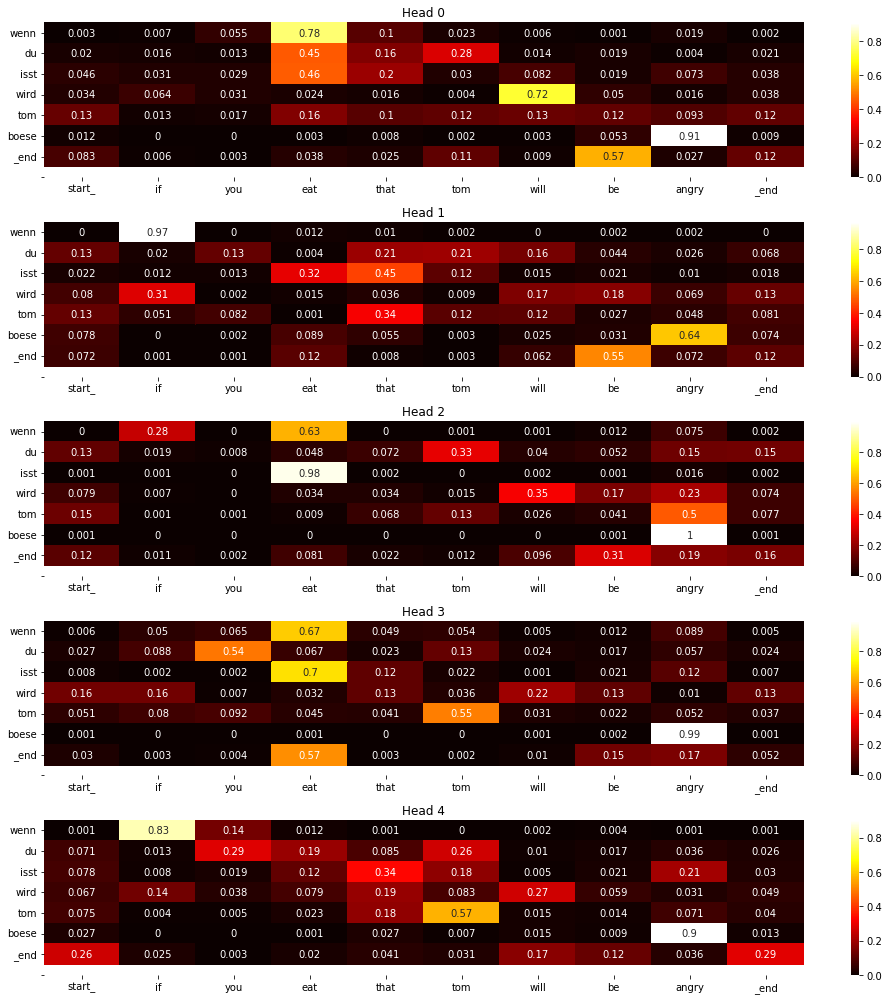

In [24]:
plot_attention_weights(pred_sentence, original_sentence, attention_weights)

In [25]:
sent_1 = 'Hello shall we go to school?'
pred_sentence, original_sentence, attention_weights = translate(sent_1, mappings, transformer, max_source_length, max_target_length)
pred_sentence, original_sentence

('hallo soll wir zur schule gehen _end ',
 'start_ hello shall we go to school _end')

decoder_layer4_block2_decenc_att


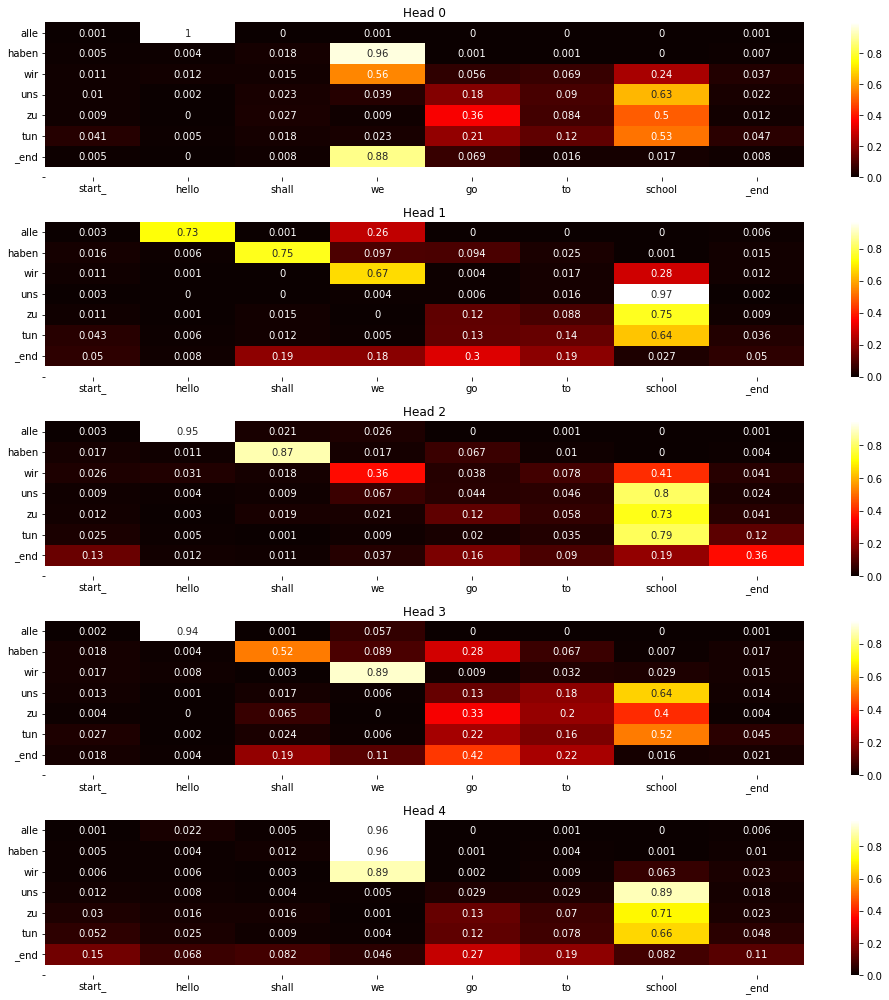

In [ ]:
plot_attention_weights(pred_sentence, original_sentence, attention_weights)